# LeNet model using Self-made Cylinder head dataset

**Note- Before running, Dataset28x28 zip file and my_utils.py file need to be uploaded in colab directory from left side.**

Pipeline consist of:
- Reading the dataset and generating the necessary dataloaders.
- Creating and initializing the model.
- Make the optimizer and the loss.
- Developing the training loop and function.
- Training and evaluating the model.

Essentials
- Cylinder Head Dataset
- Data augmentation method
- LeNet model with 2 conv2D layers and 3 FC layers.
- Loss, training & validation accuracy curves.

In [1]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22
import my_utils as mu
import torch
from torch.utils import data
import torch.nn.functional as F
from torch import nn
from IPython import display
from torchvision import datasets, transforms, models

### Unzip Image file from content directory

In [2]:
#Source (MaxInterview, n.d.)
!unzip Dataset28x28.zip

Archive:  Dataset28x28.zip
   creating: Dataset28x28/test/
   creating: Dataset28x28/test/NG_Parts/
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1393).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1394).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1395).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1396).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1397).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1398).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1399).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1400).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1401).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1402).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1403).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1404).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1405).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1406).jpg  
  inflating: Dataset28x28/test/NG_Parts/NG_10 (1407).jpg  
  inflating: Da

# 1. Reading the Dataset & Creating Dataloaders

- After running unzip command as mentioned above, a folder created in colab directory named with Dataset28x28. In Dataset28x28 folder, there are two more folders named with train & test. Below, we define the path to read the dataset from the Colab content directory. 

- Cylinder head dataset Consist of RGB images of two-wheeler cylinder head parts. This is a self-created dataset. There are 2093 training images & 800 testing images. Each sample is 28x28 pixel size and each sample is associated with the label defective or not. 

In [3]:
#Source (Stancliffe, 2018)
data_dir = '/content/Dataset28x28'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

## Data Augmentation & Transforming the dataset

- Due to less number of images, data augmentation incorporated with different filps and rotations.
- Brighness, contrast and hue factors will do the color transformation.
- Dataset will be converted into tensor and pixel size is 28x28 for LeNet model implementation.

In [4]:
# Source (Stancliffe, 2018)

training_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.2)
                                          ,transforms.ToTensor(),transforms.Resize(28),
                                          transforms.Normalize([0.5],[0.5],[0.5])])

testing_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.2)
                                          ,transforms.ToTensor(),transforms.Resize(28),
                                          transforms.Normalize([0.5],[0.5],[0.5])])

### Data Transformation

In [5]:
# Source (Stancliffe, 2018)

training_dataset = datasets.ImageFolder(train_dir,transform=training_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

## Loading dataset

- We need to specify the batch size. Following that dataset and dataloader must then be defined.
- Function **“torch.utils.data.DataLoader”** will basically create the dataset and dataloader for Cylinder head dataset.

In [6]:
# Source (Stancliffe, 2018)

train_loader = torch.utils.data.DataLoader(training_dataset,batch_size=50,shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset,batch_size=50,shuffle=True)

Training set first batch is returned by the code **next(iter(train_loader))**. By calling print(X.size()), we may display the size of X. The batch size in torch is always the first dimension, 50 in [50, 3, 28, 28]. Since RGB photos are being used, the second dimension is 3. Basically, the image's width and height are 28, 28. If we print(y), it returns a 50x1 vector. This vector's elements each stand for the corresponding class. First and second labels correspond to the classes of the first and second samples, respectively.

In [7]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22
X, y = next(iter(train_loader)) # first batch
print(X.size())
print(y)

torch.Size([50, 3, 28, 28])
tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1])


# 2. LeNet Model creation & initialization

- LeNet is already developed model with 2 convolutional layers, 2 fully connected layers and last softmax layer in the end. 
- Input and output channels in first conv layer are 3 and 6 respectively. After that in second conv layers, output channels are 16.
- Kernel size used is 5x5. Avg. pooling 2x2 and a stride of 2 is implemented. 
- All layers are defined in the constructor and implemented in forward pass.
- After each conv layer, Sigmoid and Avg pooling is applied.
- We flatten each 28x28 image and treat as a vector of length 784.
- As we have to take decision either defective product or not, so we have output dimension of 2.
- After each fully connected layer, Sigmoid activation is applied except last softmax layer.
- Softmax layer has inbuilt feature to apply cross entropy loss.

### LeNet model

In [8]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

class LeNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LeNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        C1 = 6
        C2 = 16
        L1 = 400
        L2 = 120
        L3 = 84
        self.Convl1 = nn.Conv2d(num_inputs, C1, kernel_size = 5, padding = 2)
        self.Sigmoid = nn.Sigmoid()
        self.Avg1 = nn.AvgPool2d(2, stride=2, padding=0)
        self.Convl2 = nn.Conv2d(C1,C2,kernel_size = 5)
        self.Avg2 = nn.AvgPool2d(2, stride=2, padding=0)
        self.Fltn = nn.Flatten()
        self.Linear1 = nn.Linear(L1, L2)
        self.Linear2 = nn.Linear(L2, L3)
        self.Linear3 = nn.Linear(L3, num_outputs)
    def forward(self, x):
        out = self.Convl1(x)
        out = self.Sigmoid(out)
        out = self.Avg1(out)
        out = self.Convl2(out)
        out = self.Sigmoid(out)
        out = self.Avg2(out)
       
        out = self.Fltn(out)
        out = self.Linear1(out)
        out = self.Sigmoid(out)
        out = self.Linear2(out)
        out = self.Sigmoid(out)
        out = self.Linear3(out)
       
        return out

### Xavier Weight Intialization

The Xavier Initialization procedure aims to initialise the weights so that the variance of the activations is constant throughout each layer. This constant variance helps prevent the gradient from vanishing.

In [9]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      torch.nn.init.xavier_uniform_(m.weight)          

num_outputs = 2
#model = LeNet(num_outputs)
net = LeNet(3, num_outputs)
net.apply(init_weights);
print(net)

LeNet(
  (Convl1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Sigmoid): Sigmoid()
  (Avg1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Convl2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Avg2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Fltn): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (Linear2): Linear(in_features=120, out_features=84, bias=True)
  (Linear3): Linear(in_features=84, out_features=2, bias=True)
)


# 3. Loss and Optimization Algorithm

- To get optimum accuracy, we have Choosen 'RAdam' optimizer.
- Learning rate and weight decay are set below.
- Weight decay works by adding a penalty term to the cost function of a neural network which has the effect of shrinking the weights during backpropagation. This aids in avoiding the exploding gradient problem and the network overfitting.
- net.parameters() is used to initialize an 'RAdam' optimizer.

In [10]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

# Creating loss here. Used Cross Entropy loss:
loss = nn.CrossEntropyLoss()
lr, wd = 0.01, 0
# Creating optimizer here. Used Adam with weight decay wd and learning rate lr.
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=wd)

### Accuracy

It basically involves computing the proportion of correct predictions to true labels and final output labels. Accuracy is calculated by totaling the number of correct predictions and dividing it by the total number of predictions.

In [11]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.


### Accumulator

- Accumulator records two things. The number of right predictions, which accuracy delivers, and the number of predictions per class, which y.numel provides ().
- All of the accurate predictions are combined and averaged by the accumulater.

In [12]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

- **for _, (X, y) in enumerate(data_iter)**, all batches in our dataset are iterated through for loop. And for each batch X, we compute the model output.  
- **metric.add(accuracy(net(X), y), y.numel())**, In order to obtain the accuracy for each batch, we pass the yhat & y from this accuracy function. The accumulator object is then sent it by using the formula **metric = Accumulator(2).

In [13]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 4. Training function

* We'll do a thorough sweep over the dataset for each epoch, iteratively gathering one minibatch of inputs and ground-truth labels.
* Create predictions for each minibatch by executing "net(X)" and figure out the loss "l." (the forward pass).
* Calculate gradients by running the backpropagation.
* Update the model parameters by calling our optimizer.
* Compute the loss after each epoch and print it to monitor progress.

In [14]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

def train_epoch_ch3(net, train_loader, loss, optimizer):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_loader: 
        # Compute gradients and update parameters
        y_hat = net(X) # Get the output
        l = loss(y_hat, y) # Calculate the loss
        optimizer.zero_grad() # Will clear the gradients for my parameters
        l.backward() # call backward on loss for calculating new gradients
        optimizer.step() # This will update the weights
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel()) # Pass thru the accumulator object
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

### Training
* The following class will be used to plot training and validation accuracy as well as loss evolution over training loop 

In [15]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# Training

* The following code runs the model "net" for the specified number of epochs on a training set "train loader.
* The model is assessed using the testing set "test loader" at the conclusion of each epoch.
* To visualise the training process, use a "animator."

In [16]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22

def train_ch3(net, train_loader, test_loader, loss, num_epochs, optimizer):  #@save
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_loader, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_loader)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 1, train_loss
    assert train_acc <= 1 and train_acc > 0.1, train_acc
    assert test_acc <= 1 and test_acc > 0.1, test_acc

# 5. Training, test accuracy & loss curves

* These curves are all depend on choosed parameters,hyperparameters,activation function,optimization algorithm and weight initialization method.

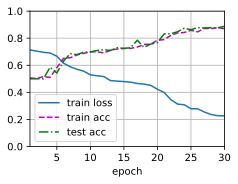

In [17]:
# Source (qmplus.qmul.ac.uk, n.d.) ECS659U/ ECS659P - NEURAL NETWORKS AND DEEP LEARNING 2021/22
num_epochs = 30
train_ch3(net, train_loader, test_loader, loss, num_epochs, optimizer)

# Training set accuracy = 89.2%

In [18]:
evaluate_accuracy(net, train_loader)

0.8920210224558051

# Validation set accuracy = 89%

In [19]:
evaluate_accuracy(net, test_loader)

0.89

### The loss, training, and validation set curves are shown in the graph above.**Achieved training accuracy 89.2% & validation accuracy of 89%.** As we can see, the training and validation accuracy curves are very near to each other. It implies that any unknown data can be incorporated into our model. As the number of epochs rises, the loss is also decreasing as shown by the downward slope of the loss curve.

I have tried different combinations of hyperparameters & parameters as mentioned in research paper to optimize the accuracy.

**Model final hyperparameters & parameters**

- Learning rate = 0.01
- Avg. Pooling, Stride = 2, Kernel = 5x5
- Batch size = 50
- Weight decay = 0
- RAdam optimizer
- 28x28 pixel size
- Weight initialization = Xavier

# References

1. Stancliffe, P. (2018). Udacity-Image-Classifier. [online] GitHub. Available at: https://github.com/paulstancliffe/Udacity-Image-Classifier/blob/master/train.py [Accessed 30 July 2022].

2. MaxInterview (n.d.). MaxInterview - unzip a file in google colab. [online] MaxInterview - unzip a file in google colab. Available at: https://maxinterview.com/code/unzip-a-file-in-google-colab-88A9863F4F6ADBE/ [Accessed 30 July 2022].

3. pytorch.org. (n.d.). Training a Classifier — PyTorch Tutorials 1.5.0 documentation. [online] Available at: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. [Accessed 30 July 2022].

4. qmplus.qmul.ac.uk. (n.d.). QMplus - The Online Learning Environment of Queen Mary University of London: Log in to the site. [online] Available at: https://qmplus.qmul.ac.uk/course/view.php?id=15432 [Accessed 30 July 2022].